In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [3]:
# Step 1: Load dataset
file_path = "/home/u1531276/home/Desktop/mi_data.csv"
df = pd.read_csv(file_path)

In [4]:
# Step 2: Drop features with >50% missing values
missing_percent = df.isnull().mean()
df_cleaned = df.drop(columns=missing_percent[missing_percent > 0.5].index)

In [5]:
# Step 3: Identify feature types
num_vars, binary_vars, ordinal_vars = [], [], []
for col in df_cleaned.columns:
    if col == 'LET_IS':
        continue
    unique_vals = df_cleaned[col].dropna().unique()
    if df_cleaned[col].dtype in ['float64', 'int64']:
        if len(unique_vals) == 2:
            binary_vars.append(col)
        elif len(unique_vals) <= 10:
            ordinal_vars.append(col)
        else:
            num_vars.append(col)

In [6]:
# Step 4: Impute missing values
df_imputed = df_cleaned.copy()
df_imputed[num_vars] = SimpleImputer(strategy='median').fit_transform(df_imputed[num_vars])
df_imputed[ordinal_vars] = SimpleImputer(strategy='median').fit_transform(df_imputed[ordinal_vars])
df_imputed[binary_vars] = SimpleImputer(strategy='most_frequent').fit_transform(df_imputed[binary_vars])


In [7]:
# Step 5: Create binary version of LET_IS
df_imputed["LET_IS_BIN"] = (df_imputed["LET_IS"] > 0).astype(int)

/tmp/ipykernel_324232/158690100.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_imputed["LET_IS_BIN"] = (df_imputed["LET_IS"] > 0).astype(int)


In [8]:
# Step 6: Drop rows with missing complication targets
target_columns = [
    'FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
    'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS'
]
df_final = df_imputed[df_imputed[target_columns].notnull().all(axis=1)].copy()

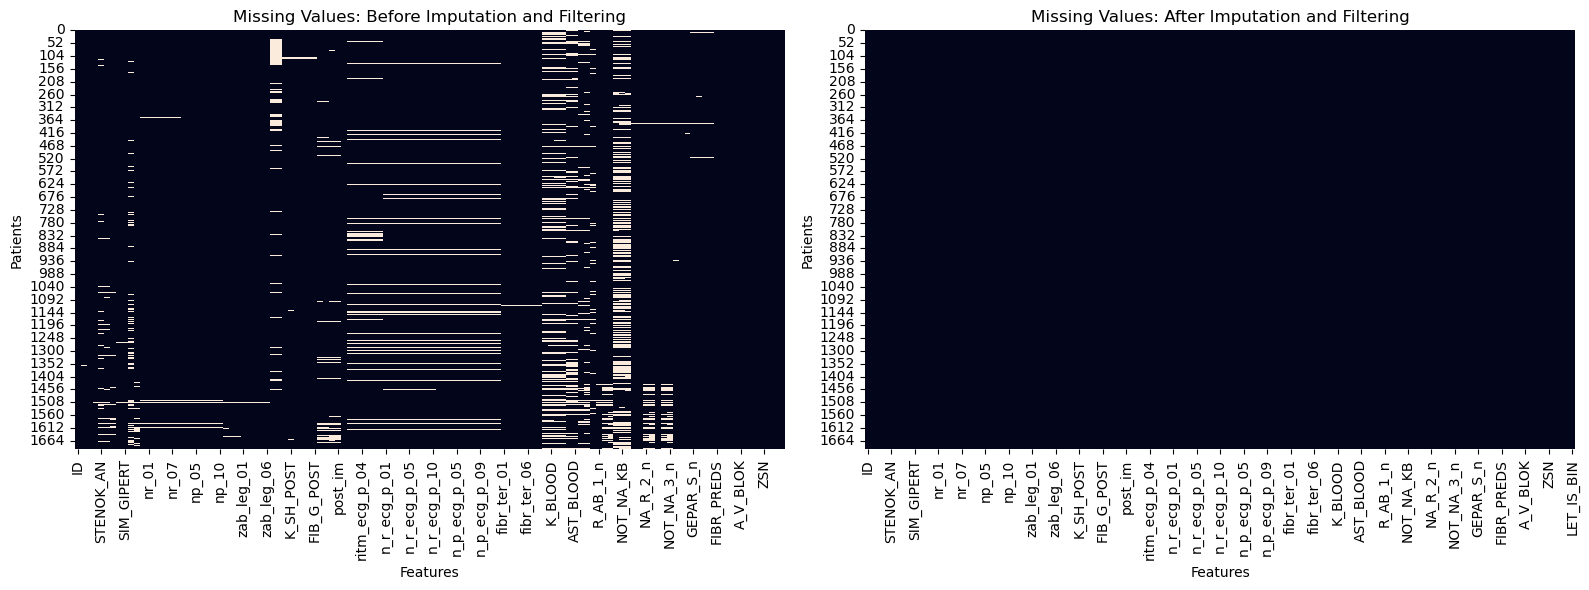

In [9]:
# Step 7: Visualize missing values before/after
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(df_cleaned.isnull(), cbar=False, ax=axes[0])
axes[0].set_title("Missing Values: Before Imputation and Filtering")
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Patients")
sns.heatmap(df_final.isnull(), cbar=False, ax=axes[1])
axes[1].set_title("Missing Values: After Imputation and Filtering")
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Patients")
plt.tight_layout()
plt.show()

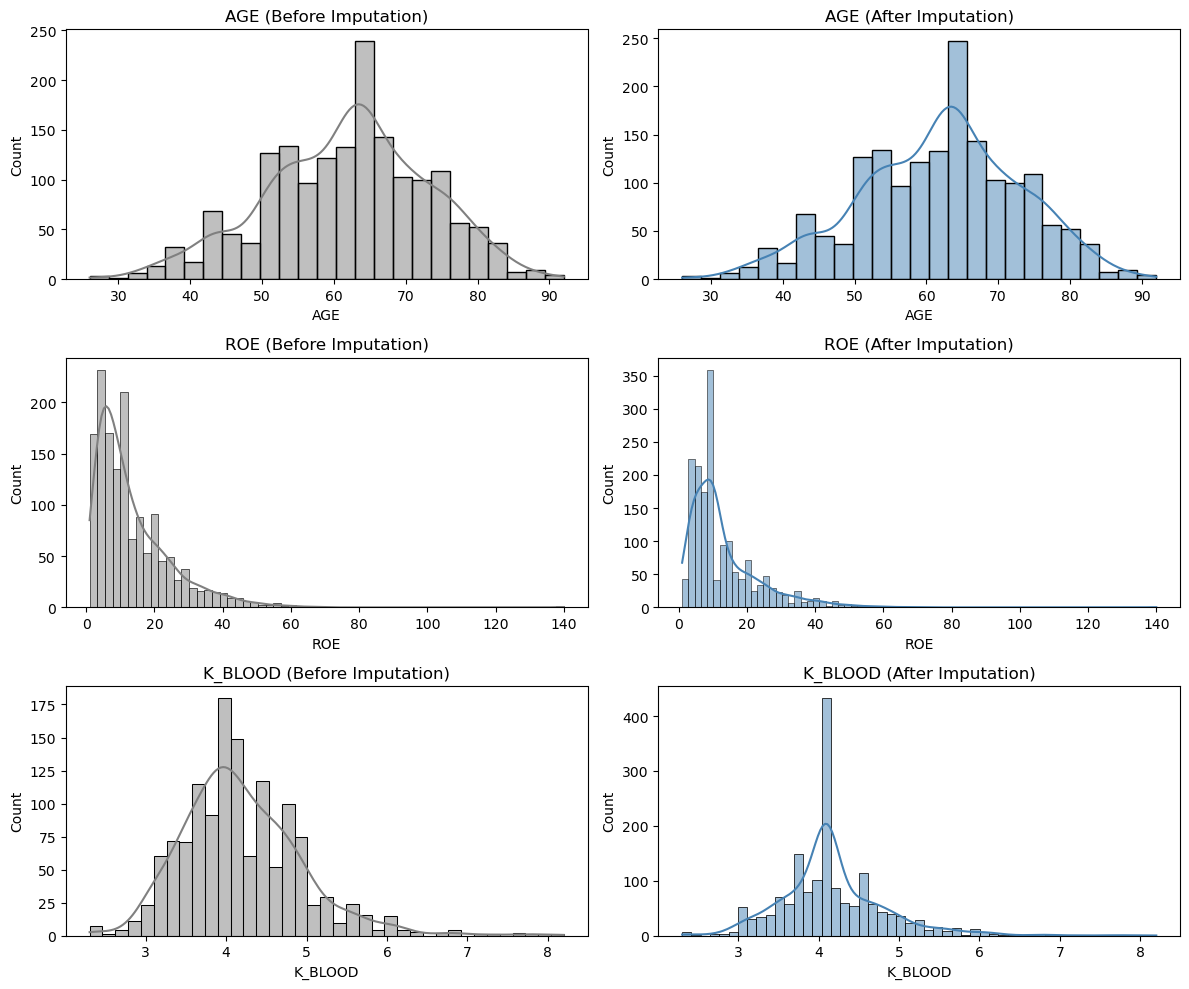

In [10]:
# Step 8: Distribution plots of selected features
key_features = ['AGE', 'ROE', 'K_BLOOD']
fig, axes = plt.subplots(len(key_features), 2, figsize=(12, 10))
for i, feature in enumerate(key_features):
    if feature in df_cleaned.columns:
        sns.histplot(df_cleaned[feature], kde=True, ax=axes[i][0], color='gray')
        axes[i][0].set_title(f"{feature} (Before Imputation)")
    if feature in df_final.columns:
        sns.histplot(df_final[feature], kde=True, ax=axes[i][1], color='steelblue')
        axes[i][1].set_title(f"{feature} (After Imputation)")
plt.tight_layout()
plt.show()


In [11]:
# Step 9: Prevalence summary for complications
total_cases = len(df_final)
complications = {
    'FIBR_PREDS': "Atrial fibrillation",
    'PREDS_TAH': "Supraventricular tachycardia",
    'JELUD_TAH': "Ventricular tachycardia",
    'FIBR_JELUD': "Ventricular fibrillation",
    'A_V_BLOK': "Third-degree AV block",
    'OTEK_LANC': "Pulmonary edema",
    'RAZRIV': "Myocardial rupture",
    'DRESSLER': "Dressler syndrome",
    'ZSN': "Chronic heart failure",
    'REC_IM': "Relapse of the myocardial infarction",
    'P_IM_STEN': "Post-infarction angina",
    'LET_IS': "Lethal outcome"
}

complication_stats = []
for col in target_columns:
    if col == 'LET_IS':
        positive_cases = (df_final[col] > 0).sum()
    else:
        positive_cases = (df_final[col] == 1).sum()
    fraction = 100 * positive_cases / total_cases
    complication_stats.append([
        complications[col], col, positive_cases, round(fraction, 2)
    ])

complication_df = pd.DataFrame(
    complication_stats,
    columns=["Complication", "Code", "Positive Cases", "Prevalence (%)"]
).sort_values(by="Prevalence (%)", ascending=False).reset_index(drop=True)

In [12]:
# Optional: Display with tabulate or export
from tabulate import tabulate
print(tabulate(complication_df, headers='keys', tablefmt='grid'))

+----+--------------------------------------+------------+------------------+------------------+
|    | Complication                         | Code       |   Positive Cases |   Prevalence (%) |
+====+======================================+============+==================+==================+
|  0 | Chronic heart failure                | ZSN        |              394 |            23.18 |
+----+--------------------------------------+------------+------------------+------------------+
|  1 | Lethal outcome                       | LET_IS     |              271 |            15.94 |
+----+--------------------------------------+------------+------------------+------------------+
|  2 | Atrial fibrillation                  | FIBR_PREDS |              170 |            10    |
+----+--------------------------------------+------------+------------------+------------------+
|  3 | Pulmonary edema                      | OTEK_LANC  |              159 |             9.35 |
+----+------------------------

## Modelling

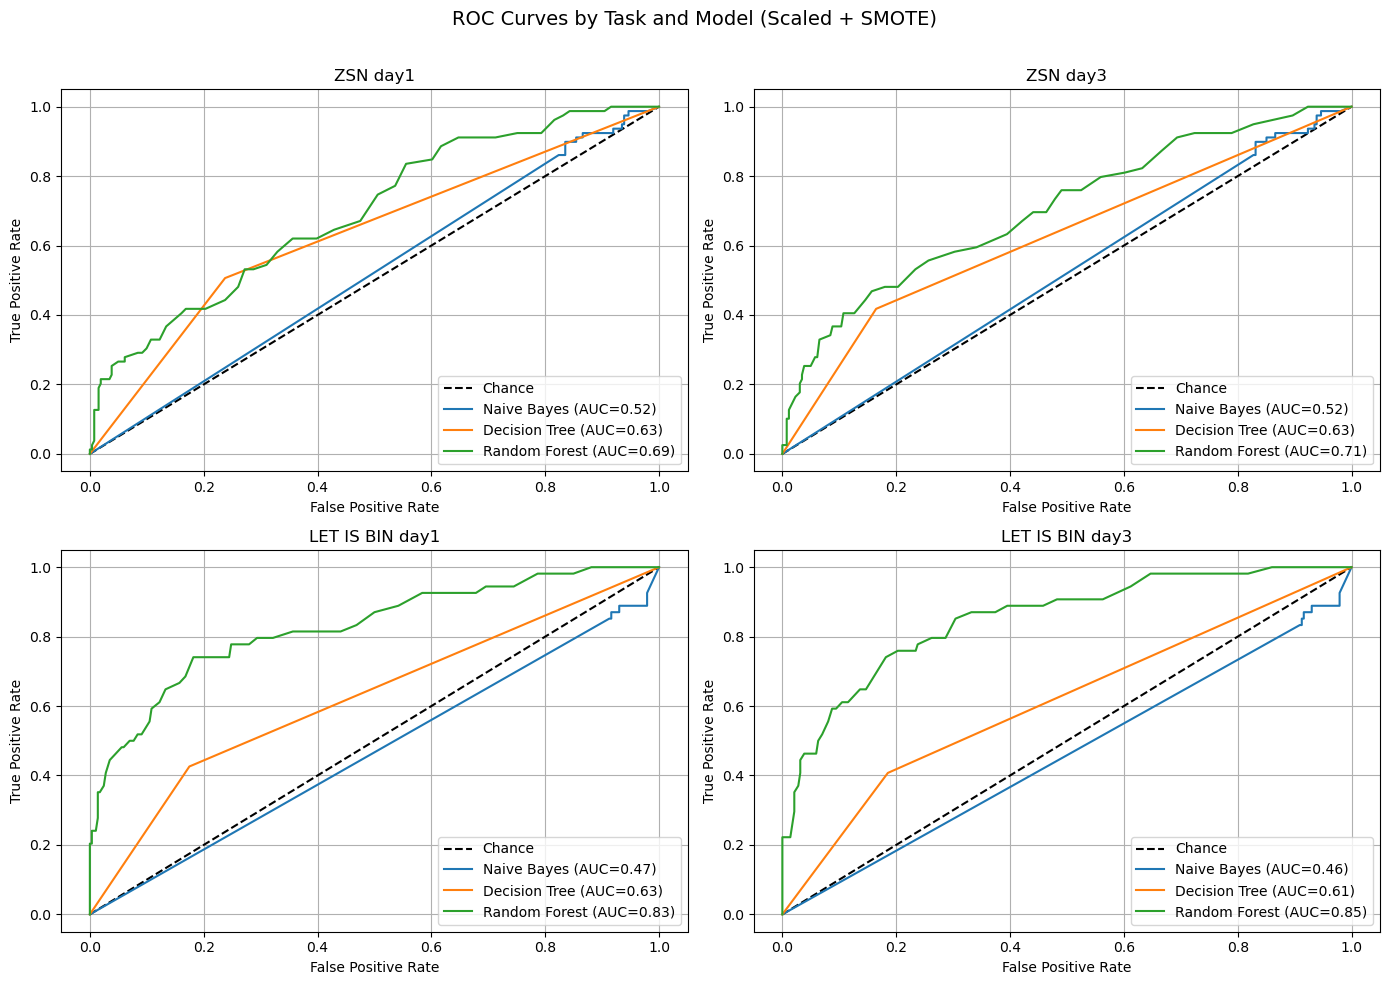

+----+-----------------+---------------+-----------+----------+------------+--------------+-----------------+
|    | Task            | Model         |   ROC AUC |   PR AUC |   Accuracy |   F1 (macro) |   F1 (weighted) |
+====+=================+===============+===========+==========+============+==============+=================+
|  0 | ZSN_day1        | Naive Bayes   |     0.52  |    0.567 |      0.318 |        0.31  |           0.271 |
+----+-----------------+---------------+-----------+----------+------------+--------------+-----------------+
|  1 | ZSN_day1        | Decision Tree |     0.634 |    0.507 |      0.703 |        0.62  |           0.715 |
+----+-----------------+---------------+-----------+----------+------------+--------------+-----------------+
|  2 | ZSN_day1        | Random Forest |     0.694 |    0.451 |      0.791 |        0.6   |           0.748 |
+----+-----------------+---------------+-----------+----------+------------+--------------+-----------------+
|  3 | ZSN

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve,
    auc, roc_curve
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd

# === Feature subsets ===
input_cols = df_final.columns[1:112]
exclude_day1 = df_final.columns[[93, 94, 100, 101, 103, 104]]
features_day1 = list(input_cols.difference(exclude_day1))
features_day3 = list(input_cols)

# === Task definitions ===
tasks = {
    "ZSN_day1": ("ZSN", features_day1),
    "ZSN_day3": ("ZSN", features_day3),
    "LET_IS_BIN_day1": ("LET_IS_BIN", features_day1),
    "LET_IS_BIN_day3": ("LET_IS_BIN", features_day3)
}

# === Models ===
base_models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
}

# === Storage ===
all_results = []
roc_data = {}

# === Pipeline Execution ===
for task_name, (target_col, features) in tasks.items():
    X = df_final[features]
    y = df_final[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    for model_name, model in base_models.items():
        pipe = ImbPipeline([
            ("scaler", StandardScaler()),
            ("smote", SMOTE(random_state=42)),
            ("clf", model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_prob = pipe.predict_proba(X_test)[:, 1]

        # Metrics
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        all_results.append({
            "Task": task_name,
            "Model": model_name,
            "ROC AUC": round(roc_auc, 3),
            "PR AUC": round(pr_auc, 3),
            "Accuracy": round(report["accuracy"], 3),
            "F1 (macro)": round(report["macro avg"]["f1-score"], 3),
            "F1 (weighted)": round(report["weighted avg"]["f1-score"], 3)
        })

        roc_data[(task_name, model_name)] = (fpr, tpr, roc_auc)

# === Format Results ===
results_df = pd.DataFrame(all_results)

# === Plot ROC Curves ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
task_titles = list(tasks.keys())

for i, ax in enumerate(axes.flat):
    task = task_titles[i]
    ax.plot([0, 1], [0, 1], 'k--', label="Chance")
    for model in base_models.keys():
        fpr, tpr, auc_val = roc_data[(task, model)]
        ax.plot(fpr, tpr, label=f"{model} (AUC={auc_val:.2f})")
    ax.set_title(task.replace("_", " "))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

plt.suptitle("ROC Curves by Task and Model (Scaled + SMOTE)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# === Display Results Table ===
from tabulate import tabulate
print(tabulate(results_df, headers="keys", tablefmt="grid"))
